In [16]:
import os
import json
import pandas as pd
from collections import defaultdict

# Folder where your game logs are stored
DATA_FOLDER = "twoDiscussion_onewerewolf_varyArchetype"

records = []

for fname in os.listdir(DATA_FOLDER):
    if not fname.endswith(".json"):
        continue
    path = os.path.join(DATA_FOLDER, fname)
    with open(path, "r") as f:
        data = json.load(f)
    
    meta = data.get("metadata", {})
    events = data.get("events", [])
    roles = meta.get("roles", {})
    
    # Identify werewolf ID(s)
    wolf_ids = [agent for agent, r in roles.items() if r == "werewolf"]
    if len(wolf_ids) != 1:
        continue
    wolf_id = wolf_ids[0]  # e.g., "Agent2"
    
    # 0th: Win?
    werewolf_win = 1 if data.get("winner") == "werewolves" else 0
    
    # 1st: Days survived
    days_survived = 0
    wolf_alive = True
    for e in events:
        if e.get("event_type") == "elimination" and e.get("target") == wolf_id:
            wolf_alive = False
            break
        if e.get("event_type") == "kill" and e.get("target") == wolf_id:
            wolf_alive = False
            break
        if e.get("phase") == "day" and e.get("event_type") == "vote_round":
            days_survived += 1
    
    # 2nd: Average votes received
    votes_against = []
    wolf_persuasion_attempts = 0
    wolf_persuasion_successes = 0
    
    for e in events:
        if e.get("event_type") == "vote_round":
            votes = e.get("votes", {})
            votes_against.append(sum(1 for v in votes.values() if v == wolf_id))
            
            # Wolf's vote
            if wolf_id in votes:
                target = votes[wolf_id]
                wolf_persuasion_attempts += 1
                # If that target was eliminated this round
                elim_event = next((ev for ev in events if ev.get("event_type") == "elimination" and ev.get("day") == e.get("day")), None)
                if elim_event and elim_event.get("target") == target:
                    wolf_persuasion_successes += 1
    
    avg_votes_against = sum(votes_against) / len(votes_against) if votes_against else 0
    wolf_persuasion_rate = (
        wolf_persuasion_successes / wolf_persuasion_attempts
        if wolf_persuasion_attempts > 0 else None
    )
    
    records.append({
        "file": fname,
        "archetype": meta.get("werewolf_archetype"),
        "n_agents": meta.get("num_agents"),
        "werewolf_win": werewolf_win,
        "days_survived": days_survived,
        "avg_votes_against": avg_votes_against,
        "wolf_persuasion_rate": wolf_persuasion_rate
    })

df = pd.DataFrame(records)
df.head()


,file,archetype,n_agents,werewolf_win,days_survived,avg_votes_against,wolf_persuasion_rate
0,game_5agents_2rounds_default_run7.json,default,5,0,2,1.50,0.0
1,game_5agents_2rounds_Accuser_run3.json,Accuser,5,0,2,0.25,0.0
2,game_5agents_2rounds_Chaos Agent_run3.json,Chaos Agent,5,0,2,0.50,0.0
3,game_5agents_2rounds_Sympathizer_run5.json,Sympathizer,5,0,2,0.50,0.0
4,game_5agents_2rounds_Deflector_run6.json,Deflector,5,0,4,1.50,0.0


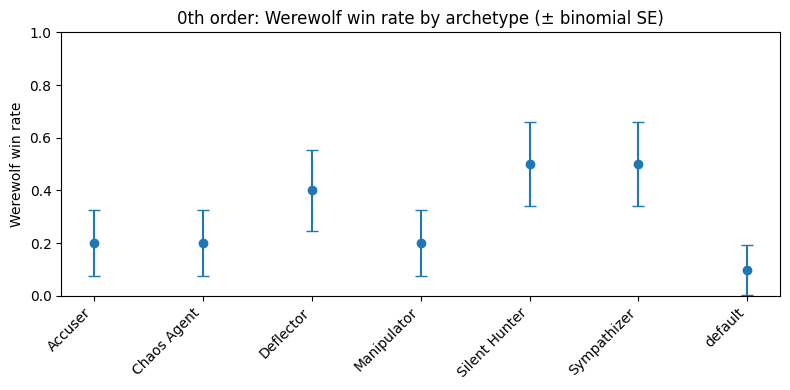

,archetype,n_games,win_rate,se
0,Accuser,10,0.2,0.126491
1,Chaos Agent,10,0.2,0.126491
2,Deflector,10,0.4,0.154919
3,Manipulator,10,0.2,0.126491
4,Silent Hunter,10,0.5,0.158114
5,Sympathizer,10,0.5,0.158114
6,default,10,0.1,0.094868


In [17]:
import numpy as np
import matplotlib.pyplot as plt

def sem(series):
    s = series.dropna()
    n = s.count()
    if n <= 1:
        return 0.0
    return s.std(ddof=1) / np.sqrt(n)

# Aggregate win rate per archetype
win_agg = df.groupby("archetype").agg(
    n_games=("werewolf_win", "count"),
    win_rate=("werewolf_win", "mean")
).reset_index()

# Binomial standard error for proportions
win_agg["se"] = np.sqrt(win_agg["win_rate"] * (1 - win_agg["win_rate"]) / win_agg["n_games"])

# Sort for stable plotting
win_agg = win_agg.sort_values("archetype").reset_index(drop=True)

# Plot
plt.figure(figsize=(8, 4))
x = np.arange(len(win_agg))
plt.errorbar(x, win_agg["win_rate"], yerr=win_agg["se"], fmt="o", capsize=4)
plt.xticks(x, win_agg["archetype"], rotation=45, ha="right")
plt.ylabel("Werewolf win rate")
plt.title("0th order: Werewolf win rate by archetype (± binomial SE)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

win_agg


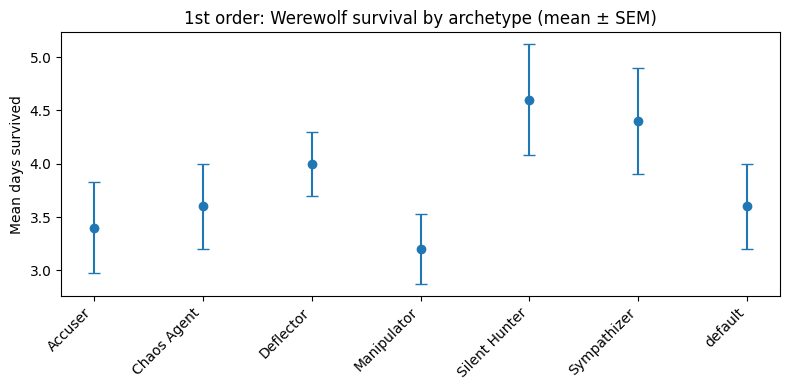

,archetype,n,mean_days,se
0,Accuser,10,3.4,0.426875
1,Chaos Agent,10,3.6,0.400000
2,Deflector,10,4.0,0.298142
3,Manipulator,10,3.2,0.326599
4,Silent Hunter,10,4.6,0.520683
5,Sympathizer,10,4.4,0.498888
6,default,10,3.6,0.400000


In [18]:
# Aggregate days survived per archetype
surv_agg = df.groupby("archetype").agg(
    n=("days_survived", "count"),
    mean_days=("days_survived", "mean"),
    se=("days_survived", sem)
).reset_index()

surv_agg = surv_agg.sort_values("archetype").reset_index(drop=True)

# Plot
plt.figure(figsize=(8, 4))
x = np.arange(len(surv_agg))
plt.errorbar(x, surv_agg["mean_days"], yerr=surv_agg["se"], fmt="o", capsize=4)
plt.xticks(x, surv_agg["archetype"], rotation=45, ha="right")
plt.ylabel("Mean days survived")
plt.title("1st order: Werewolf survival by archetype (mean ± SEM)")
plt.tight_layout()
plt.show()

surv_agg


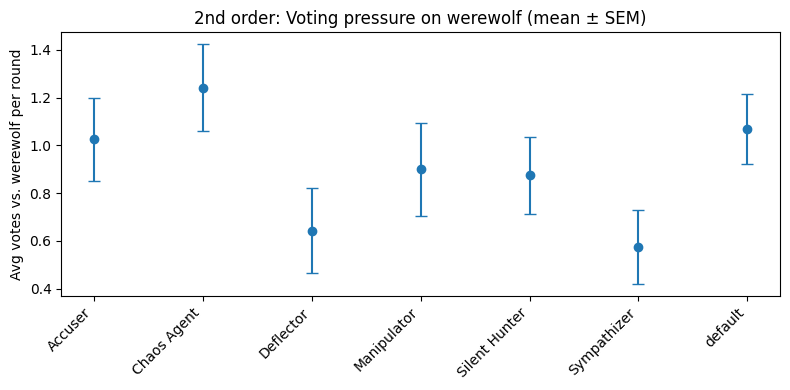

,archetype,n,mean_votes_vs_wolf,se
0,Accuser,10,1.025000,0.172603
1,Chaos Agent,10,1.241667,0.181493
2,Deflector,10,0.641667,0.177886
3,Manipulator,10,0.900000,0.194365
4,Silent Hunter,10,0.875000,0.161135
5,Sympathizer,10,0.575000,0.155382
6,default,10,1.066667,0.146881


In [19]:
# Aggregate average votes against the werewolf per round (computed per game in df)
votes_agg = df.groupby("archetype").agg(
    n=("avg_votes_against", "count"),
    mean_votes_vs_wolf=("avg_votes_against", "mean"),
    se=("avg_votes_against", sem)
).reset_index()

votes_agg = votes_agg.sort_values("archetype").reset_index(drop=True)

# Plot
plt.figure(figsize=(8, 4))
x = np.arange(len(votes_agg))
plt.errorbar(x, votes_agg["mean_votes_vs_wolf"], yerr=votes_agg["se"], fmt="o", capsize=4)
plt.xticks(x, votes_agg["archetype"], rotation=45, ha="right")
plt.ylabel("Avg votes vs. werewolf per round")
plt.title("2nd order: Voting pressure on werewolf (mean ± SEM)")
plt.tight_layout()
plt.show()

votes_agg
